# Multivariado
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from mlflow_runs import MLflowCallback
mlflow_callback = MLflowCallback()


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/air_quality_clean.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406


### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


In [3]:
# variable a predecir CO(GT) Monoxido de cárbono
X = df.drop(columns=['CO(GT)']).values
y = df['CO(GT)'].values.reshape(-1, 1)

In [4]:
# escalar con minmax scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Código de sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size].flatten())
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12 #mejro resultado
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)

In [6]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [7]:
#MLP
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop, mlflow_callback], verbose=1)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0121 - val_loss: 0.0103
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0061 - val_loss: 0.0131
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0053 - val_loss: 0.0129
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0053 - val_loss: 0.0117
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0051 - val_loss: 0.0111
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0055 - val_loss: 0.0108


In [9]:
#predecir 
y_pred = model.predict(X_test)

# Invertir escala del min max
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


In [10]:
# resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.640
MSE: 0.864
R²: 0.530


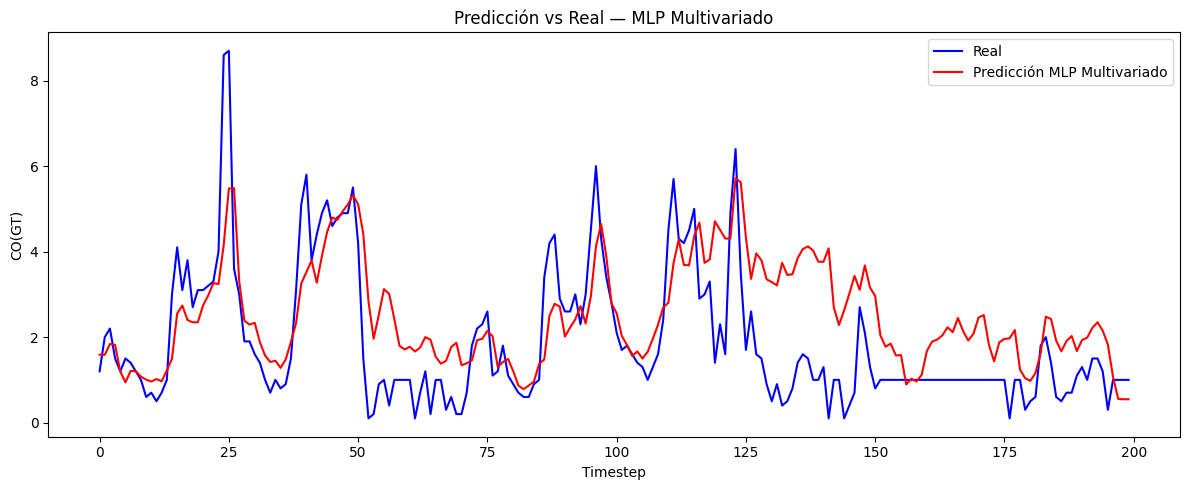

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP Multivariado', color='red')
plt.title('Predicción vs Real — MLP Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

El mejor resultado de este dio, con una ventana pequeña en el sliding window, y agregandole una capa para que fuera más profunda.

# CNN

In [35]:
#sliding window
def crear_ventanas_multivariadas(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_multivariadas(X_scaled, y_scaled, window_size)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# 1) Definir arquitectura
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),  # (timesteps, features)
    Conv1D(64, kernel_size=3, activation='relu'),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# 2) Compilar ANTES de entrenar
model.compile(
    optimizer='adam',
    loss='mse'
)

# 3) Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 4) Entrenamiento (solo UNA vez)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0092 - val_loss: 0.0147
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.0059 - val_loss: 0.0119
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0054 - val_loss: 0.0154
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0055 - val_loss: 0.0141
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0052 - val_loss: 0.0158
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0052 - val_loss: 0.0148
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0138


In [39]:
#prediccion 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


In [40]:
#resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.485
MSE: 0.779
R²: 0.576


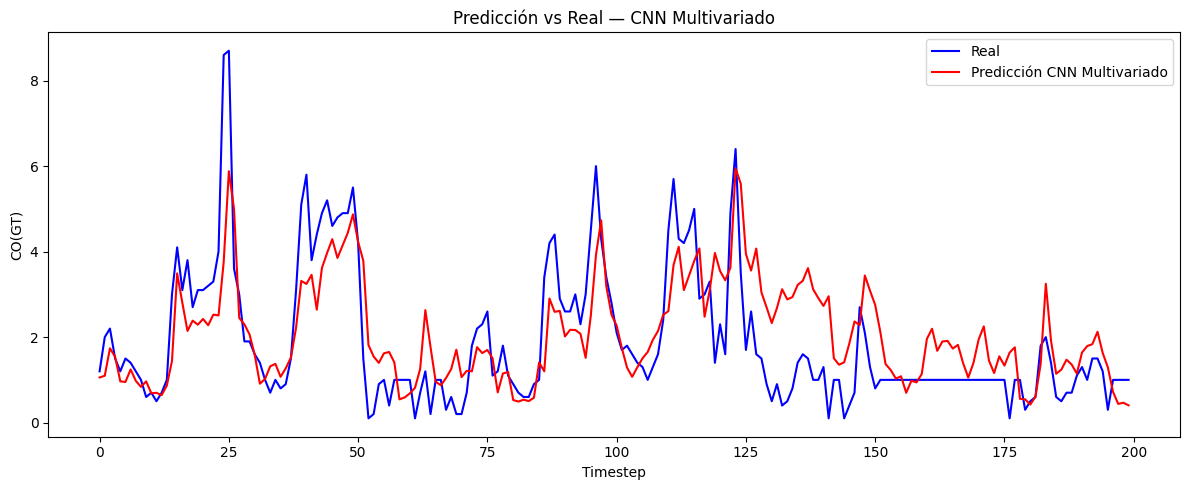

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Multivariado', color='red')
plt.title('Predicción vs Real — CNN Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo CNN multivariado obtuvo un desempeño bueno:

MAPE de 0.610, lo que indica un error relativo promedio del 61%.

MSE de 0.706, menor que el del modelo LSTM.

R² de 0.616, lo que significa que explica el 61.6% de la variabilidad en los datos reales de CO(GT).

Esto sugiere que la CNN es más precisa que el LSTM en capturar patrones multivariados de corto plazo, probablemente gracias a su capacidad para detectar patrones locales en el tiempo entre las variables.


# LSTM

In [42]:
def crear_ventanas_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_lstm(X_scaled, y_scaled, window_size)

In [43]:
#LSTM multivariado
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(window_size, X_seq.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0129
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - val_loss: 0.0157
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0154
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0123
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0133
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0125
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0142
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0144
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0134


In [44]:
# Predecir
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [45]:
# Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


MAPE: 0.440
MSE: 0.840
R²: 0.544


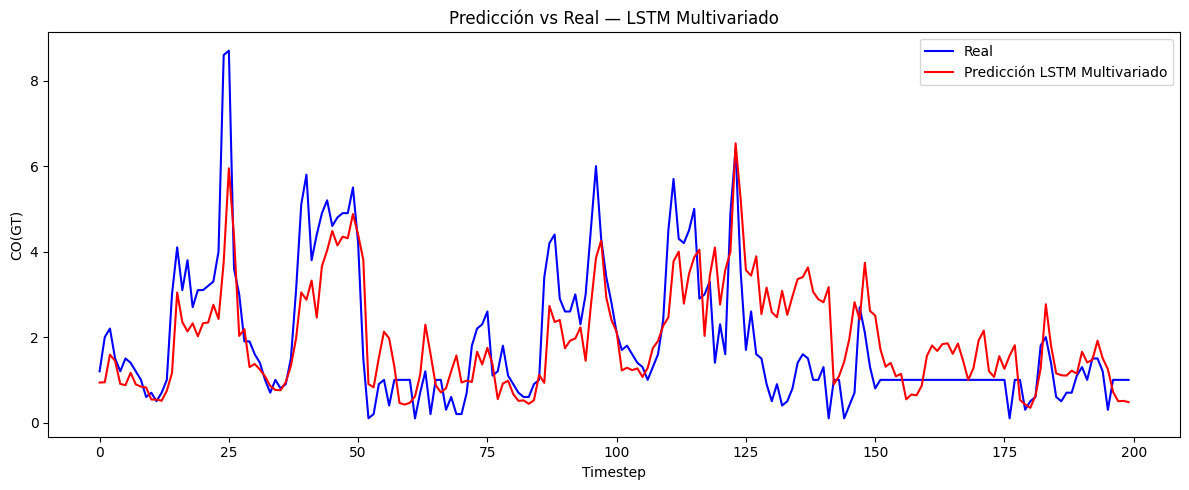

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM Multivariado', color='red')
plt.title('Predicción vs Real — LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El modelo LSTM tiene un resultado aceptable. Predice de manera correcta el 57% de lla variablidad de los datos. No es el mejor de mis modelos. Tiene bastante error proporcional (MAPE = 0.684), lo que sugiere, Fluctuaciones o picos difíciles de aprender

# CONV-LSTM

In [47]:
def crear_ventanas_conv_lstm(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_conv_lstm(X_scaled, y_scaled, window_size)

In [48]:
# Conv-LSTM 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Entrenar 
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - val_loss: 0.0127
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0132
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0149
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0137
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0160
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0131


In [49]:
# Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [50]:
#Resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.481
MSE: 0.860
R²: 0.533


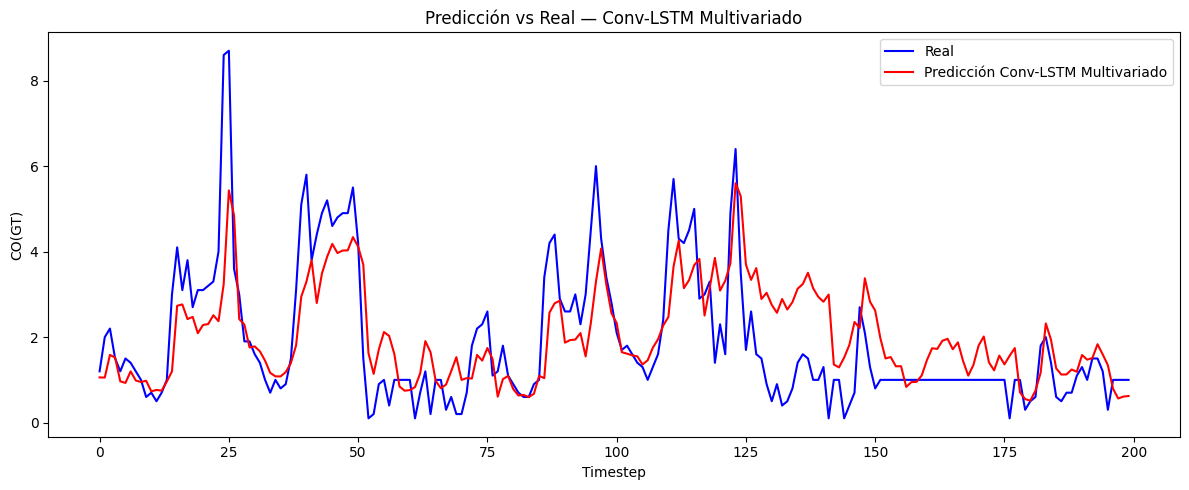

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM Multivariado', color='red')
plt.title('Predicción vs Real — Conv-LSTM Multivariado')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Aunque el modelo Conv-LSTM combina la estructura de CNN y LSTM, en este caso no logró superar a los modelos individuales.
Este modelo aprende 53 % la variabilidad de los datos. 

# OPTUNA

In [52]:
def objective(trial):
    filters = trial.suggest_categorical('filters', [32, 64, 128])
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dense_units = trial.suggest_int('dense_units', 32, 128)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Modelo CNN
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamiento
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=50,
              batch_size=batch_size,
              callbacks=[early_stop, mlflow_callback],
              verbose=0)

    # Predicción
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    return r2_score(y_test_inv, y_pred_inv)


In [ ]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor R² obtenido: {study.best_value:.3f}")

[I 2025-05-13 23:18:46,835] A new study created in memory with name: no-name-aa9eb366-c319-401f-9cfa-e1530ba78639
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


[I 2025-05-13 23:18:48,900] Trial 0 finished with value: 0.5797771503819904 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 82, 'activation': 'tanh', 'lr': 0.00035181165485212977, 'batch_size': 64}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


[I 2025-05-13 23:18:51,300] Trial 1 finished with value: 0.5547048604414206 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 118, 'activation': 'relu', 'lr': 0.00020622593530978588, 'batch_size': 16}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


[I 2025-05-13 23:18:52,269] Trial 2 finished with value: 0.5222058737506703 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 36, 'activation': 'relu', 'lr': 0.007292362276639885, 'batch_size': 64}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


[I 2025-05-13 23:18:54,128] Trial 3 finished with value: 0.570128302130118 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 68, 'activation': 'relu', 'lr': 0.009297688214145795, 'batch_size': 32}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


[I 2025-05-13 23:18:57,040] Trial 4 finished with value: 0.5123542401847352 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 122, 'activation': 'tanh', 'lr': 0.0018487962940721058, 'batch_size': 16}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


[I 2025-05-13 23:18:58,145] Trial 5 finished with value: 0.5555785644309723 and parameters: {'filters': 32, 'kernel_size': 2, 'dense_units': 35, 'activation': 'tanh', 'lr': 0.002059188535761517, 'batch_size': 64}. Best is trial 0 with value: 0.5797771503819904.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


[I 2025-05-13 23:19:00,185] Trial 6 finished with value: 0.6007560867065718 and parameters: {'filters': 64, 'kernel_size': 4, 'dense_units': 121, 'activation': 'relu', 'lr': 0.0018136239158997505, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


[I 2025-05-13 23:19:01,674] Trial 7 finished with value: 0.5535459855152486 and parameters: {'filters': 32, 'kernel_size': 4, 'dense_units': 42, 'activation': 'relu', 'lr': 0.006185401275160083, 'batch_size': 16}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


[I 2025-05-13 23:19:03,491] Trial 8 finished with value: 0.5050783637999199 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 105, 'activation': 'tanh', 'lr': 0.0011112118095628412, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


[I 2025-05-13 23:19:04,680] Trial 9 finished with value: 0.5039951690670539 and parameters: {'filters': 32, 'kernel_size': 4, 'dense_units': 112, 'activation': 'relu', 'lr': 0.005068124220742389, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


[I 2025-05-13 23:19:06,097] Trial 10 finished with value: 0.5645026840274914 and parameters: {'filters': 64, 'kernel_size': 2, 'dense_units': 92, 'activation': 'relu', 'lr': 0.0003346575808636434, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


[I 2025-05-13 23:19:07,696] Trial 11 finished with value: 0.5356430548086547 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 71, 'activation': 'tanh', 'lr': 0.0005096952314849596, 'batch_size': 64}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


[I 2025-05-13 23:19:08,927] Trial 12 finished with value: 0.41304845153444036 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 90, 'activation': 'tanh', 'lr': 0.00013237856292930647, 'batch_size': 64}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


[I 2025-05-13 23:19:10,343] Trial 13 finished with value: 0.5636596054486178 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 57, 'activation': 'tanh', 'lr': 0.0006013251157796737, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


[I 2025-05-13 23:19:11,414] Trial 14 finished with value: 0.5367986135032543 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 97, 'activation': 'relu', 'lr': 0.00287903081662052, 'batch_size': 64}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


[I 2025-05-13 23:19:13,211] Trial 15 finished with value: 0.5771003949743677 and parameters: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'activation': 'tanh', 'lr': 0.0009723115573393004, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


[I 2025-05-13 23:19:15,580] Trial 16 finished with value: 0.5792020901993115 and parameters: {'filters': 128, 'kernel_size': 3, 'dense_units': 73, 'activation': 'relu', 'lr': 0.00031887334275278254, 'batch_size': 64}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


[I 2025-05-13 23:19:17,859] Trial 17 finished with value: 0.5093196505377766 and parameters: {'filters': 128, 'kernel_size': 5, 'dense_units': 54, 'activation': 'tanh', 'lr': 0.0009306969534986196, 'batch_size': 32}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


[I 2025-05-13 23:19:20,206] Trial 18 finished with value: 0.5805681261680748 and parameters: {'filters': 64, 'kernel_size': 5, 'dense_units': 104, 'activation': 'relu', 'lr': 0.0001330738998535914, 'batch_size': 64}. Best is trial 6 with value: 0.6007560867065718.
/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Extraer mejores hiperparámetros
params = study.best_params

filters = params['filters']
kernel_size = params['kernel_size']
dense_units = params['dense_units']
activation = params['activation']
learning_rate = params['lr']
batch_size = params['batch_size']

In [ ]:
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(dense_units, activation=activation))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Entrenamiento final con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0186 - val_loss: 0.0133
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - val_loss: 0.0111
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0144
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0142
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0112
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0132
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0122
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0121
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0121


In [ ]:
# Predicción
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

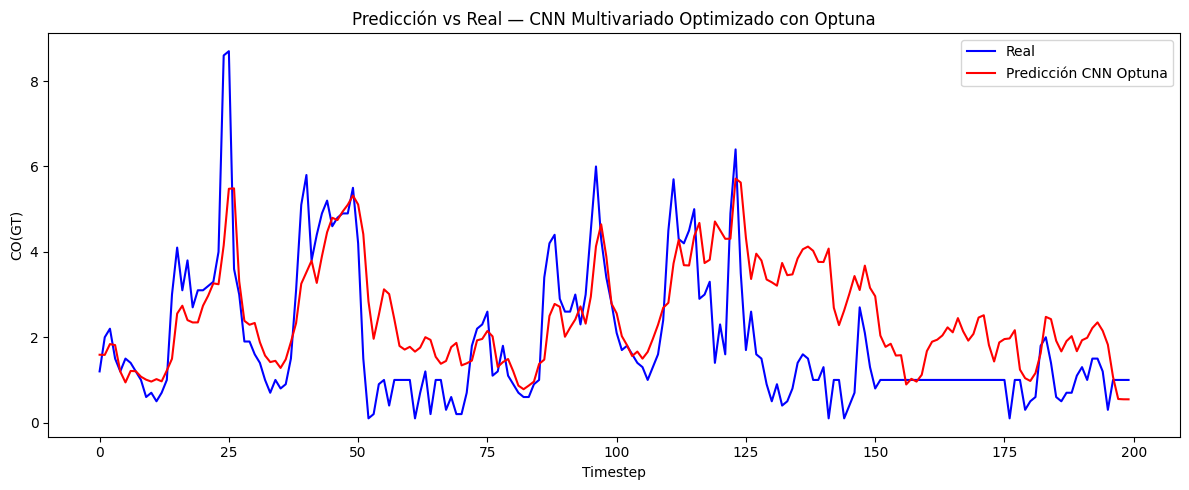

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Optuna', color='red')
plt.title('Predicción vs Real — CNN Multivariado Optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo prácticamente el mismo resultado en la r2. Aún asi se ajusta de manera aceptable a los datois la predicción.

Los resultados no fueron tan bienos como los modelos que solo usaban una variable. Lo que podriamos hacer es usar menos variables para hacer el modelo. Esto lo intentaremos con el mejor modelo a parte del optuna.

In [ ]:
# Calcular correlación
correlaciones = df.corr(numeric_only=True)['CO(GT)'].drop('CO(GT)').sort_values(key=abs, ascending=False)

# Mostrar
print(correlaciones)


PT08.S2(NMHC)    0.767366
C6H6(GT)         0.762027
PT08.S1(CO)      0.751593
PT08.S5(O3)      0.742271
PT08.S3(NOx)    -0.608512
PT08.S4(NO2)     0.508368
RH               0.037791
AH              -0.029071
T               -0.017483
Name: CO(GT), dtype: float64


Basado en los resultados de tu análisis de correlación con CO(GT), podemos seleccionar las 5 variables más relevantes:
1. PT08.S2(NMHC)

2. C6H6(GT)

3. PT08.S1(CO)

4. PT08.S5(O3)

5. PT08.S3(NOx)

In [ ]:
# Seleccionar solo las variables más relevantes
variables_seleccionadas = ['PT08.S2(NMHC)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S5(O3)', 'PT08.S3(NOx)']
X = df[variables_seleccionadas].values
y = df['CO(GT)'].values.reshape(-1, 1)


Ahora usaré el mejor modelo que fue la cnn con estas variables

In [ ]:
#Escalar
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
#Crear ventanas para CNN 
def crear_ventanas_cnn(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size, :])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 12
X_seq, y_seq = crear_ventanas_cnn(X_scaled, y_scaled, window_size)


In [ ]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# Modelo CNN multivariado reducido 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Capa extra
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- EarlyStopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Entrenar ---
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Downloads/Air_Quality_Pred_Clas-main/.vnev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100 - val_loss: 0.0155
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0059 - val_loss: 0.0139
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0055 - val_loss: 0.0150
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 0.0126
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0050 - val_loss: 0.0170
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0053 - val_loss: 0.0188
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0049 - val_loss: 0.0158
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0049 - val_loss: 0.0129
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 0.0147


In [ ]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


In [ ]:
#resultados
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.503
MSE: 0.805
R²: 0.563


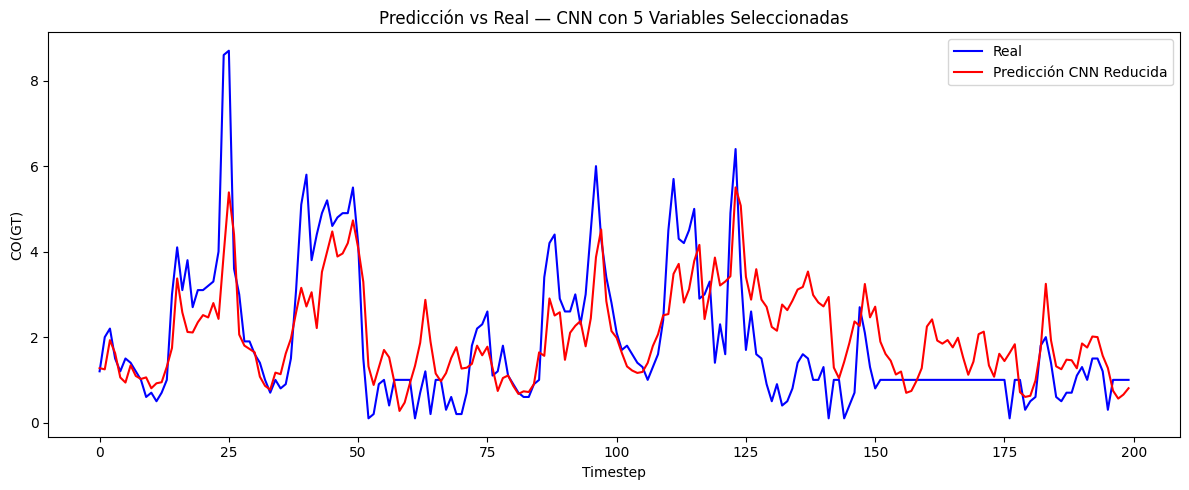

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN Reducida', color='red')
plt.title('Predicción vs Real — CNN con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


MAPE fue mejor con solo 5 variables → El modelo fue más preciso proporcionalmente.

Pero R² fue ligeramente menor, indicando que explicó un poco menos de la variabilidad total.

Esto sugiere que las 5 variables principales contienen la mayor parte de la información útil, pero las otras variables todavía aportan algo (aunque poco).



# MLP con 5 variables

In [ ]:

# Crear ventanas (MLP requiere 2D, ventana aplanada)
def crear_ventanas_mlp(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        ventana = X[i:i+window_size].flatten()
        Xs.append(ventana)
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_seq, y_seq = crear_ventanas_mlp(X_scaled, y_scaled, window_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), 
    Flatten(),                                           
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(32,  activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0186 - val_loss: 0.0129
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.0055 - val_loss: 0.0146
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0055 - val_loss: 0.0145
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0055 - val_loss: 0.0131
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.0054 - val_loss: 0.0131
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.0052 - val_loss: 0.0121
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0049 - val_loss: 0.0128
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0054 - val_loss: 0.0120
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0052 - val_loss: 0.0152
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.0052 - val_loss: 0.0154
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.0052 - val_loss: 0.0173
Epoch 12/50
187/187 ━━━━━━━━━━

In [ ]:
#Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


In [ ]:
# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.550
MSE: 0.679
R²: 0.631


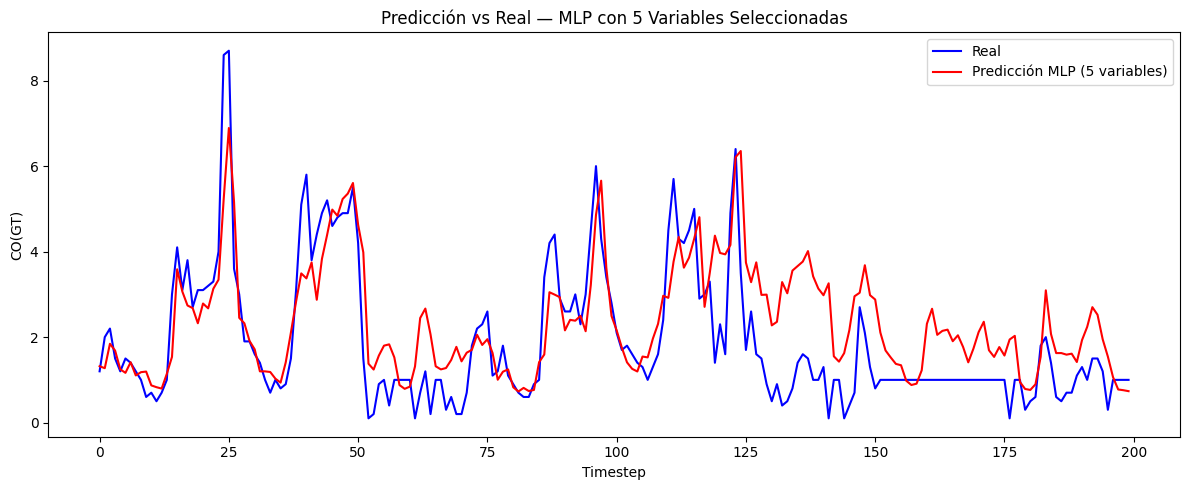

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción MLP (5 variables)', color='red')
plt.title('Predicción vs Real — MLP con 5 Variables Seleccionadas')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


Obtuvo mejor resultado con todas las variables, muy poquita diferencia 2%. Pero aún así es mayor

Eliminar variables no siempre mejora R², aunque puede reducir MAPE (error relativo).

Las variables eliminadas quizás no están fuertemente correlacionadas individualmente, pero sí aportan al modelo de forma conjunta.

Para redes neuronales, a veces más variables (aunque ruidosas) permiten aprender mejor la estructura de los datos.